In [1]:
%matplotlib inline

import sys
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import logging

from collections import OrderedDict
from itertools import combinations
from IPython.core.debugger import set_trace

In [2]:
logging.basicConfig(level=logging.DEBUG)

# Code

In [32]:
eps = np.finfo(float).eps

def my_pairplot(df_orig, df_target, bins, size=3):
    orig_cols = df_orig.columns
    target_cols = df_target.columns
    
    orig_count = len(df_orig)
    target_count = len(df_target)
    
    dims = len(orig_cols)
    
    figsize = (dims*size, dims*size)
    
    fig, axes = plt.subplots(dims, dims, figsize=figsize)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for i in range(dims):
        for j in range(dims):
            ax = axes[i][j]

            ax.set_xticks([])
            ax.set_yticks([])

            ax.set_xticklabels([])
            ax.set_yticklabels([])

            if i==dims-1:
                ax.set_xlabel(orig_cols[j])

            if j==0:
                ax.set_ylabel(target_cols[i])
    
            if i==j:
                h = ax.hist(
                    [df_orig[orig_cols[j]], df_target[target_cols[i]]], label=['orig', 'target'],
                    histtype='step', density=True, bins=bins, range=[0,1]
                )[0]
                H = sp.stats.entropy(h[0]+eps, h[1]+eps)

                ax.set_xlim([0,1])
                ax.set_ylim([0,None])

                ax.text(0.02, 0.98, 'H = {0:.4f}'.format(H), horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)

                if i==0:
                    ax.legend(loc='best')

            if i>j:
                h_orig = np.histogram2d(df_orig[orig_cols[i]], df_orig[orig_cols[j]], bins=bins, range=[[0,1],[0,1]])[0] / orig_count
                h_target = np.histogram2d(df_target[target_cols[i]], df_target[target_cols[j]], bins=bins, range=[[0,1],[0,1]])[0] / target_count

                h = h_target.T-h_orig.T
                vlim = max(abs(h.min()), abs(h.max()))
                
                ax.pcolormesh(h, cmap='bwr', vmin=-vlim, vmax=+vlim)

            if i<j:
                h = ax.hist(
                    [df_orig[orig_cols[i]]-df_orig[orig_cols[j]], df_target[target_cols[i]]-df_target[target_cols[j]]],
                    histtype='step', density=True, bins=bins,
                )[0]
                H = sp.stats.entropy(h[0]+eps, h[1]+eps)
                
                ax.text(0.02, 0.98, 'H = {0:.4f}'.format(H), horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)

In [86]:
def my_colorplot(df_orig, df_target, df_result, bins=100, size=3):
    colors = zip(
        df_orig.columns[:-1],
        df_orig.columns[1:],
    )
    color_pairs = list(combinations(colors, 2))
    
    nrows = len(color_pairs)
    
    figsize = (3*size, nrows*size)
    
    x_lim = np.empty((3, 2))
    y_lim = np.empty((3, 2))
    
    fig, ax = plt.subplots(nrows, 3, figsize=figsize)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    if nrows == 1:
        ax = [ax]
    
    for i, (a, b) in enumerate(color_pairs):
        ax[i][0].hist2d(
            df_orig[a[0]] - df_orig[a[1]],
            df_orig[b[0]] - df_orig[b[1]],
            bins=bins, norm=mpl.colors.LogNorm()
        )
        x_lim[0] = ax[i][0].get_xlim()
        y_lim[0] = ax[i][0].get_ylim()
        
        ax[i][1].hist2d(
            df_target[a[0]] - df_target[a[1]],
            df_target[b[0]] - df_target[b[1]],
            bins=bins, norm=mpl.colors.LogNorm()
        )
        x_lim[1] = ax[i][1].get_xlim()
        y_lim[1] = ax[i][1].get_ylim()
        
        ax[i][2].hist2d(
            df_result[a[0]] - df_result[a[1]],
            df_result[b[0]] - df_result[b[1]],
            bins=bins, norm=mpl.colors.LogNorm()
        )
        x_lim[2] = ax[i][2].get_xlim()
        y_lim[2] = ax[i][2].get_ylim()
        
        ax[i][0].set_ylabel('{0} - {1}'.format(b[0], b[1]))
        for j in range(3):
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
            ax[i][j].set_xticklabels([])
            ax[i][j].set_yticklabels([])
            ax[i][j].set_xlim([x_lim[:2,0].min(), x_lim[:2,1].max()])
            ax[i][j].set_ylim([y_lim[:2,0].min(), y_lim[:2,1].max()])
        
        ax2 = ax[i][j].twinx()
        ax2.set_yticks([])
        ax2.set_yticklabels([])
        ax2.set_ylabel('{0} - {1}'.format(a[0], a[1]))
            
    ax[0][0].set_title('orig')
    ax[0][1].set_title('target')
    ax[0][2].set_title('result')

### Linear Monge-Kantorovitch

In [5]:
from colour_transfer import colour_transfer_mkl

### Iterative Distribution Transfer

In [6]:
from colour_transfer import colour_transfer_idt

# Photographs

In [88]:
im_orig = plt.imread('scotland_house.png')
im_target = plt.imread('scotland_plain.png')

df_orig = pd.DataFrame(im_orig.reshape(-1, im_orig.shape[-1]), columns=['r', 'g', 'b'])
df_target = pd.DataFrame(im_target.reshape(-1, im_target.shape[-1]), columns=['r', 'g', 'b'])

a_orig = df_orig.values
a_target = df_target.values

In [89]:
df_result = pd.DataFrame(colour_transfer_mkl(a_orig, a_target), columns=['r', 'g', 'b'])

a_result = df_result.values
im_result = a_result.reshape(im_orig.shape)

Text(0.5,1,'result')

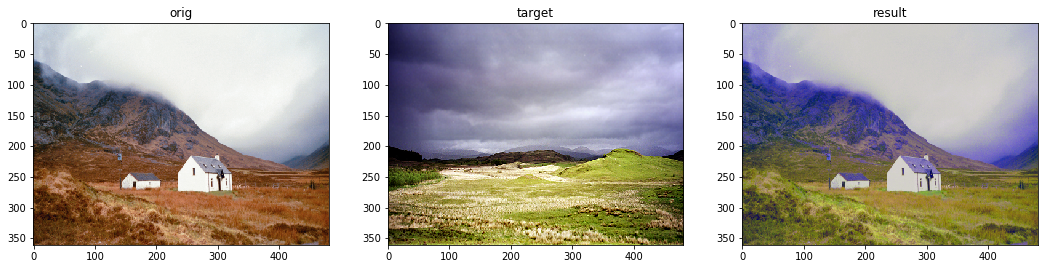

In [90]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))
ax[0].imshow(im_orig)
ax[0].set_title('orig')
ax[1].imshow(im_target)
ax[1].set_title('target')
ax[2].imshow(im_result)
ax[2].set_title('result')

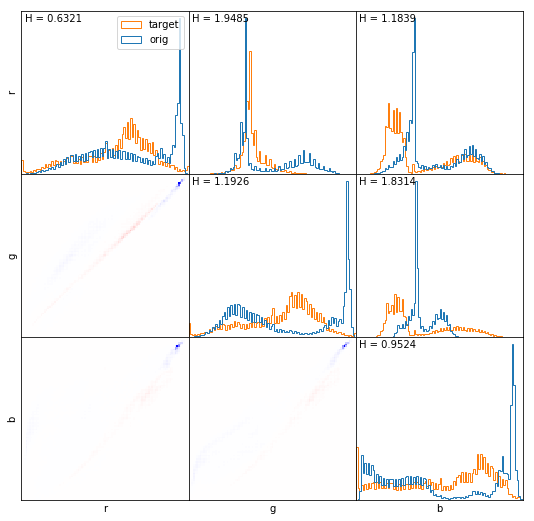

In [91]:
my_pairplot(df_orig, df_target, bins=100)

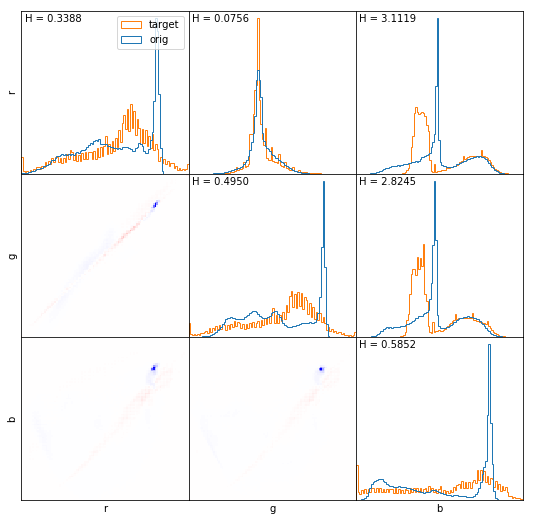

In [92]:
my_pairplot(df_result, df_target, bins=100)

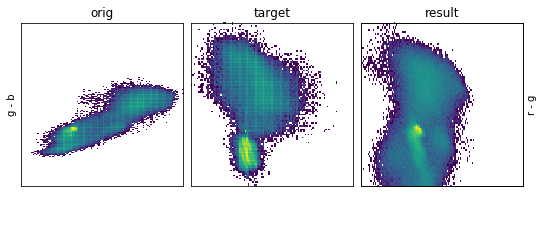

In [93]:
my_colorplot(df_orig, df_target, df_result, bins=100)

In [94]:
np.random.seed(42)
bins = 100

a_result = colour_transfer_idt(a_orig, a_target, bins=300, n_rot=20, relaxation=1)

df_result = pd.DataFrame(a_result, columns=['r', 'g', 'b'])
im_result = a_result.reshape(im_orig.shape)

DEBUG:colour_transfer:Iteration 1/20 completed.
DEBUG:colour_transfer:Iteration 2/20 completed.
DEBUG:colour_transfer:Iteration 3/20 completed.
DEBUG:colour_transfer:Iteration 4/20 completed.
DEBUG:colour_transfer:Iteration 5/20 completed.
DEBUG:colour_transfer:Iteration 6/20 completed.
DEBUG:colour_transfer:Iteration 7/20 completed.
DEBUG:colour_transfer:Iteration 8/20 completed.
DEBUG:colour_transfer:Iteration 9/20 completed.
DEBUG:colour_transfer:Iteration 10/20 completed.
DEBUG:colour_transfer:Iteration 11/20 completed.
DEBUG:colour_transfer:Iteration 12/20 completed.
DEBUG:colour_transfer:Iteration 13/20 completed.
DEBUG:colour_transfer:Iteration 14/20 completed.
DEBUG:colour_transfer:Iteration 15/20 completed.
DEBUG:colour_transfer:Iteration 16/20 completed.
DEBUG:colour_transfer:Iteration 17/20 completed.
DEBUG:colour_transfer:Iteration 18/20 completed.
DEBUG:colour_transfer:Iteration 19/20 completed.
DEBUG:colour_transfer:Iteration 20/20 completed.


Text(0.5,1,'result')

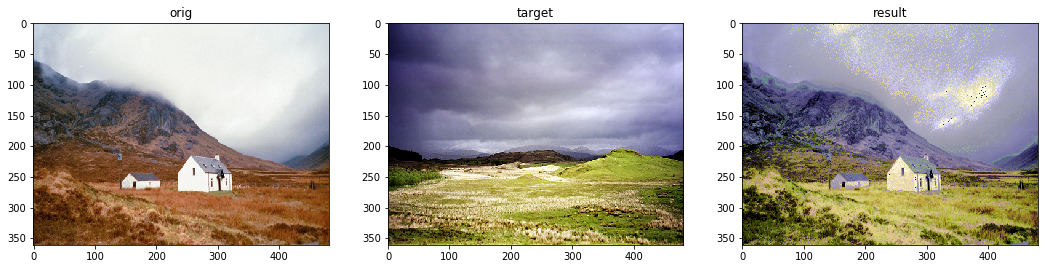

In [95]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))
ax[0].imshow(im_orig)
ax[0].set_title('orig')
ax[1].imshow(im_target)
ax[1].set_title('target')
ax[2].imshow(im_result)
ax[2].set_title('result')

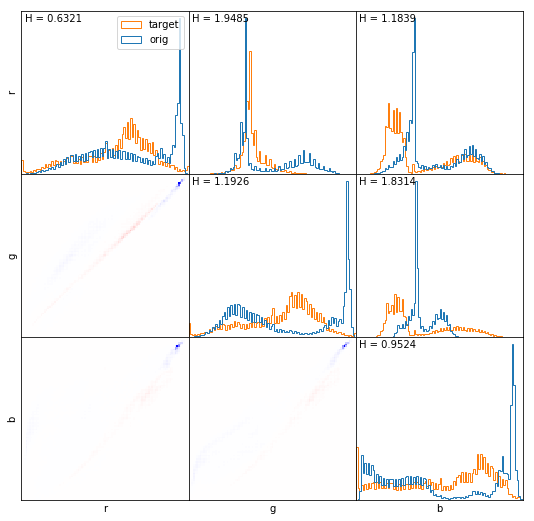

In [96]:
my_pairplot(df_orig, df_target, bins=bins, size=3)

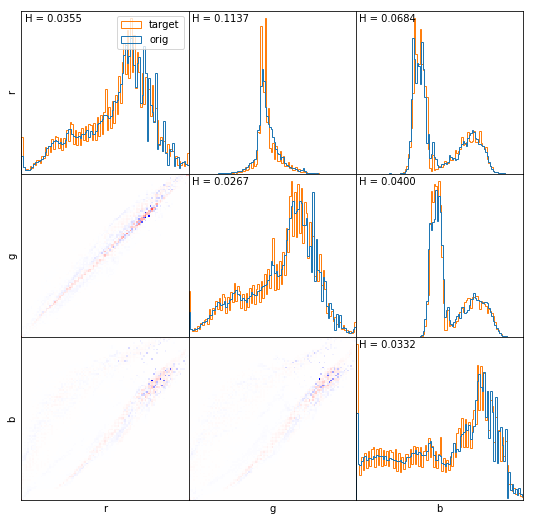

In [97]:
my_pairplot(df_result, df_target, bins=bins, size=3)

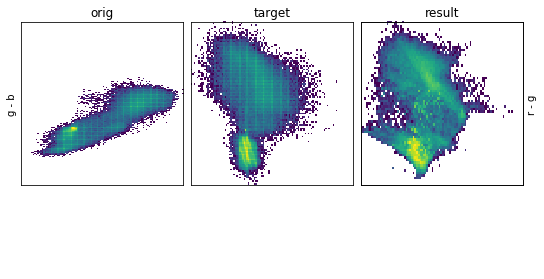

In [98]:
my_colorplot(df_orig, df_target, df_result, bins=bins)

# Galaxies

In [99]:
path = '/nfs/astro/tallada/tmp/MICE_remap_DES/'

colors = [
    'g',
    'r',
    'i',
    'z'
]

des_names = [
    'sof_cm_mag_corrected_g',
    'sof_cm_mag_corrected_r',
    'sof_cm_mag_corrected_i',
    'sof_cm_mag_corrected_z',
]

mice_names = [
    'des_asahi_full_g_true',
    'des_asahi_full_r_true',
    'des_asahi_full_i_true',
    'des_asahi_full_z_true',
]

nrows = int(1e6)

In [100]:
with open(path + 'DES_4780.csv') as file:
    df_des = pd.read_csv(
        file, sep=',', comment='#', na_values = '\\N', nrows=nrows, dtype=np.float32,
        index_col=['coadd_object_id'], usecols=['coadd_object_id'] + des_names,
    )

with open(path + 'MICE2_4779.csv') as file:
    df_mice = pd.read_csv(
        file, sep=',', comment='#', na_values = '\\N', nrows=nrows, dtype=np.float32,
        index_col=['unique_gal_id'], usecols=['unique_gal_id'] + mice_names,
    )
    
f_path = '/nfs/astro/tallada/tmp/MICE_remap_DES/'

In [101]:
l_des = len(df_des)
l_mice = len(df_mice)

In [102]:
df_des.rename(columns=dict(zip(des_names, colors)), inplace=True)
df_mice.rename(columns=dict(zip(mice_names, colors)), inplace=True)

In [103]:
# Compute ranges
ranges = pd.concat(
    [
        df_des.agg(['min', 'max']),
        df_mice.agg(['min', 'max']),
    ]
).agg(['min', 'max'])
ranges

,g,r,i,z
min,12.286614,11.895095,11.698073,11.400957
max,28.862000,26.758560,25.855646,26.361492


In [104]:
# Normalize
df_des = ((df_des - ranges.loc['min']) / (ranges.loc['max'] - ranges.loc['min']))
df_mice = ((df_mice - ranges.loc['min']) / (ranges.loc['max'] - ranges.loc['min']))

In [105]:
np.random.seed(42)
bins = 300

a_result = colour_transfer_idt(df_mice.values, df_des.values, bins=bins, n_rot=200, relaxation=0.2)

df_result = pd.DataFrame(a_result, columns=colors)

DEBUG:colour_transfer:Iteration 1/200 completed.
DEBUG:colour_transfer:Iteration 2/200 completed.
DEBUG:colour_transfer:Iteration 3/200 completed.
DEBUG:colour_transfer:Iteration 4/200 completed.
DEBUG:colour_transfer:Iteration 5/200 completed.
DEBUG:colour_transfer:Iteration 6/200 completed.
DEBUG:colour_transfer:Iteration 7/200 completed.
DEBUG:colour_transfer:Iteration 8/200 completed.
DEBUG:colour_transfer:Iteration 9/200 completed.
DEBUG:colour_transfer:Iteration 10/200 completed.
DEBUG:colour_transfer:Iteration 11/200 completed.
DEBUG:colour_transfer:Iteration 12/200 completed.
DEBUG:colour_transfer:Iteration 13/200 completed.
DEBUG:colour_transfer:Iteration 14/200 completed.
DEBUG:colour_transfer:Iteration 15/200 completed.
DEBUG:colour_transfer:Iteration 16/200 completed.
DEBUG:colour_transfer:Iteration 17/200 completed.
DEBUG:colour_transfer:Iteration 18/200 completed.
DEBUG:colour_transfer:Iteration 19/200 completed.
DEBUG:colour_transfer:Iteration 20/200 completed.
DEBUG:col

DEBUG:colour_transfer:Iteration 164/200 completed.
DEBUG:colour_transfer:Iteration 165/200 completed.
DEBUG:colour_transfer:Iteration 166/200 completed.
DEBUG:colour_transfer:Iteration 167/200 completed.
DEBUG:colour_transfer:Iteration 168/200 completed.
DEBUG:colour_transfer:Iteration 169/200 completed.
DEBUG:colour_transfer:Iteration 170/200 completed.
DEBUG:colour_transfer:Iteration 171/200 completed.
DEBUG:colour_transfer:Iteration 172/200 completed.
DEBUG:colour_transfer:Iteration 173/200 completed.
DEBUG:colour_transfer:Iteration 174/200 completed.
DEBUG:colour_transfer:Iteration 175/200 completed.
DEBUG:colour_transfer:Iteration 176/200 completed.
DEBUG:colour_transfer:Iteration 177/200 completed.
DEBUG:colour_transfer:Iteration 178/200 completed.
DEBUG:colour_transfer:Iteration 179/200 completed.
DEBUG:colour_transfer:Iteration 180/200 completed.
DEBUG:colour_transfer:Iteration 181/200 completed.
DEBUG:colour_transfer:Iteration 182/200 completed.
DEBUG:colour_transfer:Iteration

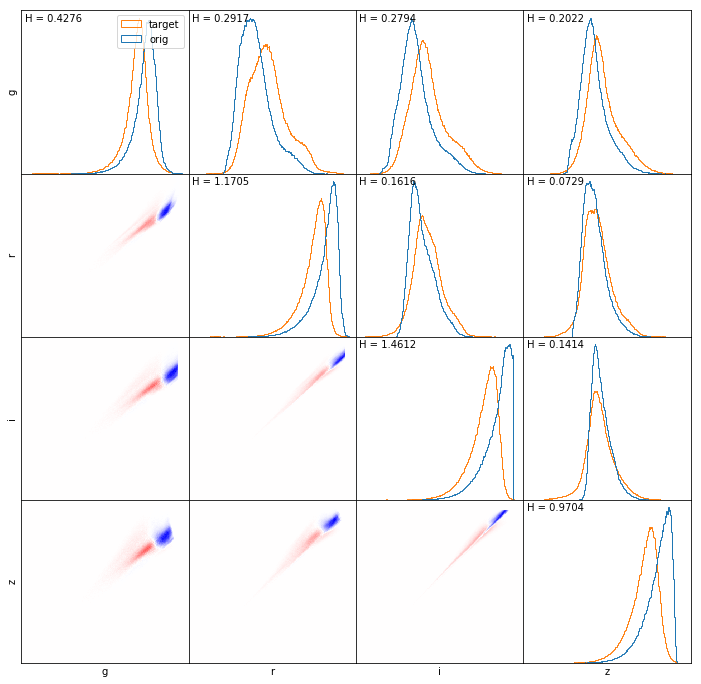

In [106]:
my_pairplot(df_mice, df_des, bins=bins, size=3)

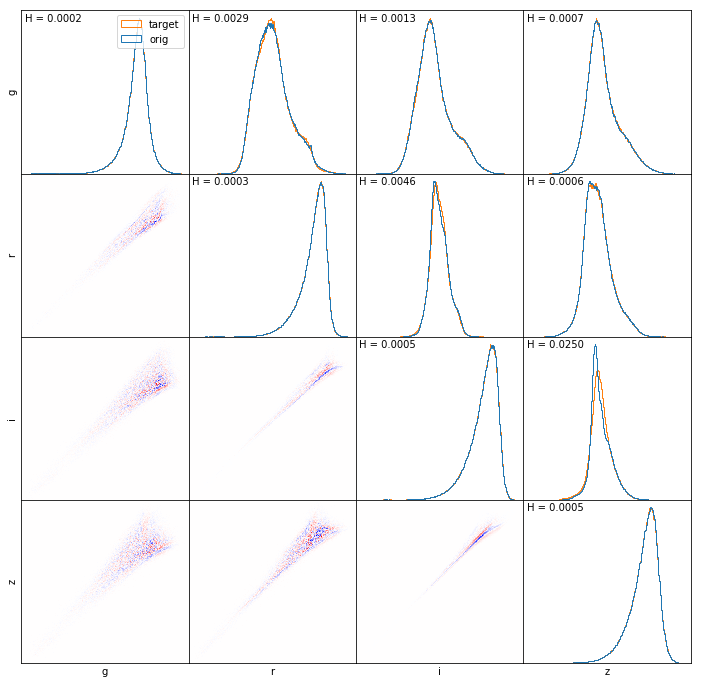

In [107]:
my_pairplot(df_result, df_des, bins=bins, size=3)

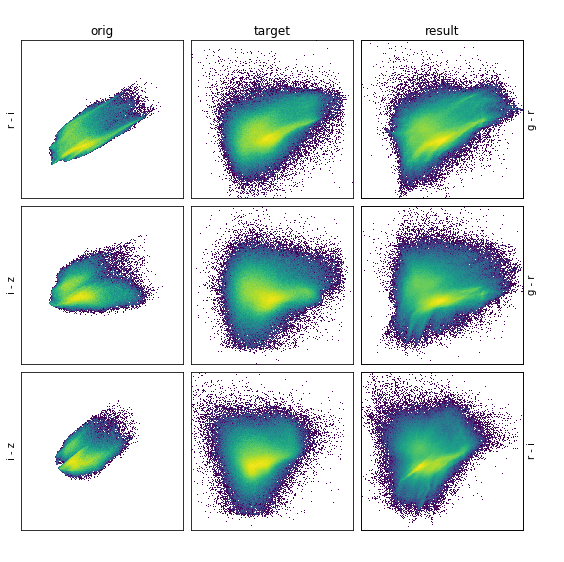

In [108]:
my_colorplot(df_mice, df_des, df_result, bins=bins, size=3)